# Generation of bliss heatmaps for NRAS<sup>Q61</sup> melanoma cells

This script generates bliss heatmaps describing the regieon of synergistic drug interactions of RAF (belvarafenib) and MEK inhibitors (cobimetinib) for simulated NRAS<sup>Q61</sup> cells. CRAF feedback effects are shown by generating heatmaps with and without CRAF feedback.

## Import of libraries
Importing libraries necessary to generate bliss heatmaps.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from synergy.combination import Bliss
import numpy as np
import os
from pathlib import Path
plt.rcParams.update({'font.size': 15})
#import synergy package 
from synergy.combination import Bliss

Changes to main file directory. This works provided the "main_dir" has the correct directory name and the cwd starts within the main file directory. This might require tweaking under some high performance computing setups.

In [13]:
main_dir = "MARM2_Andrew_8_24"
for i in Path().resolve().parents:
    if i.parts[-1] == main_dir:
        os.chdir(i)

## Generate bliss heatmaps (relative weighting)

0.05901683384516551 1.8740807162124826 1.8740807162124826
0.11963261328654667 1.0 1.0


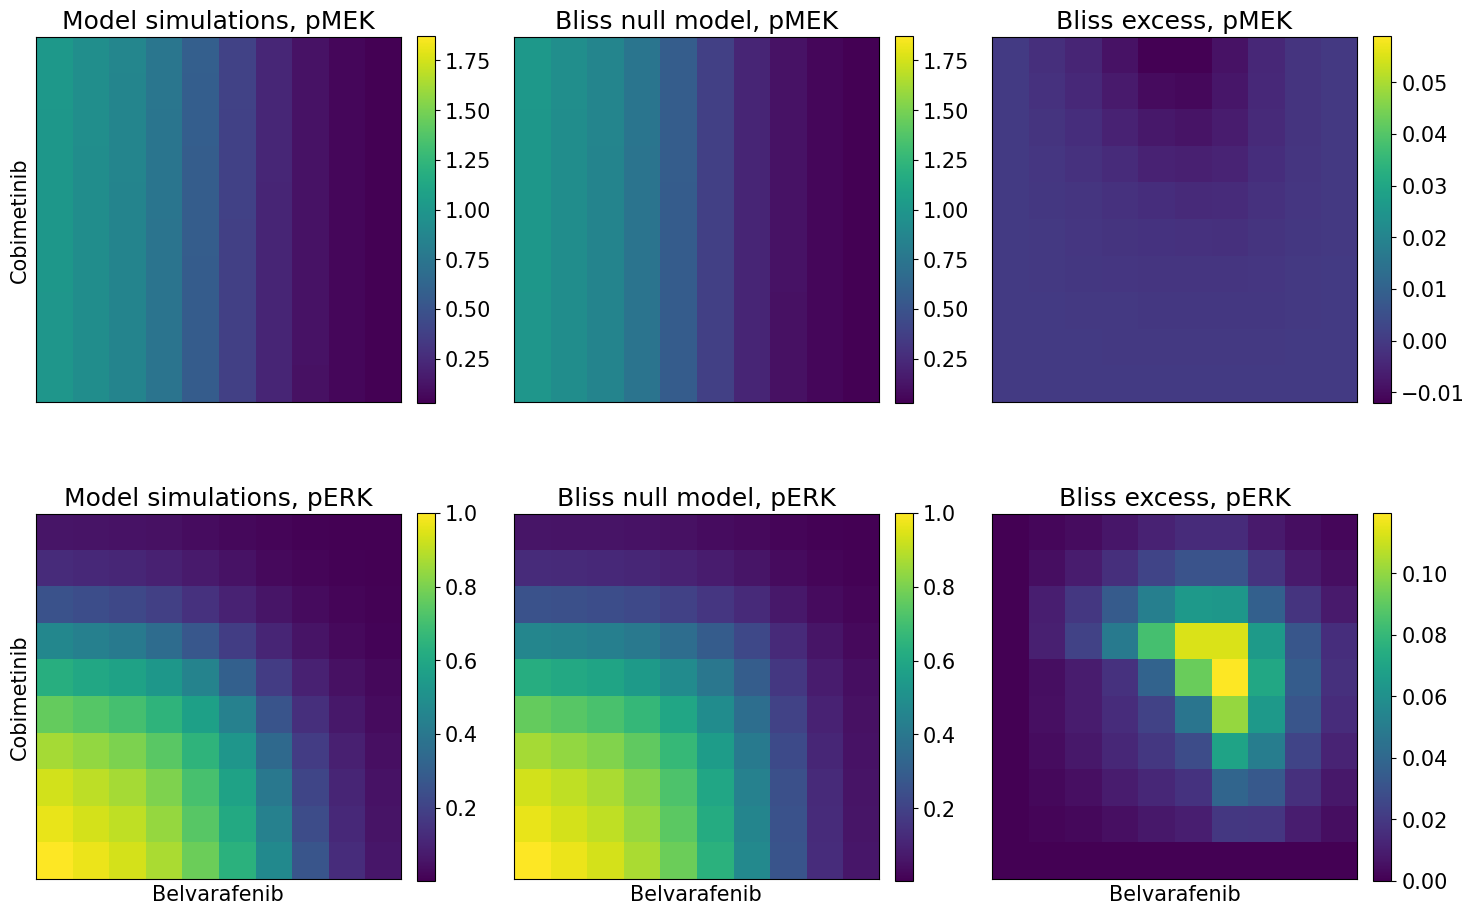

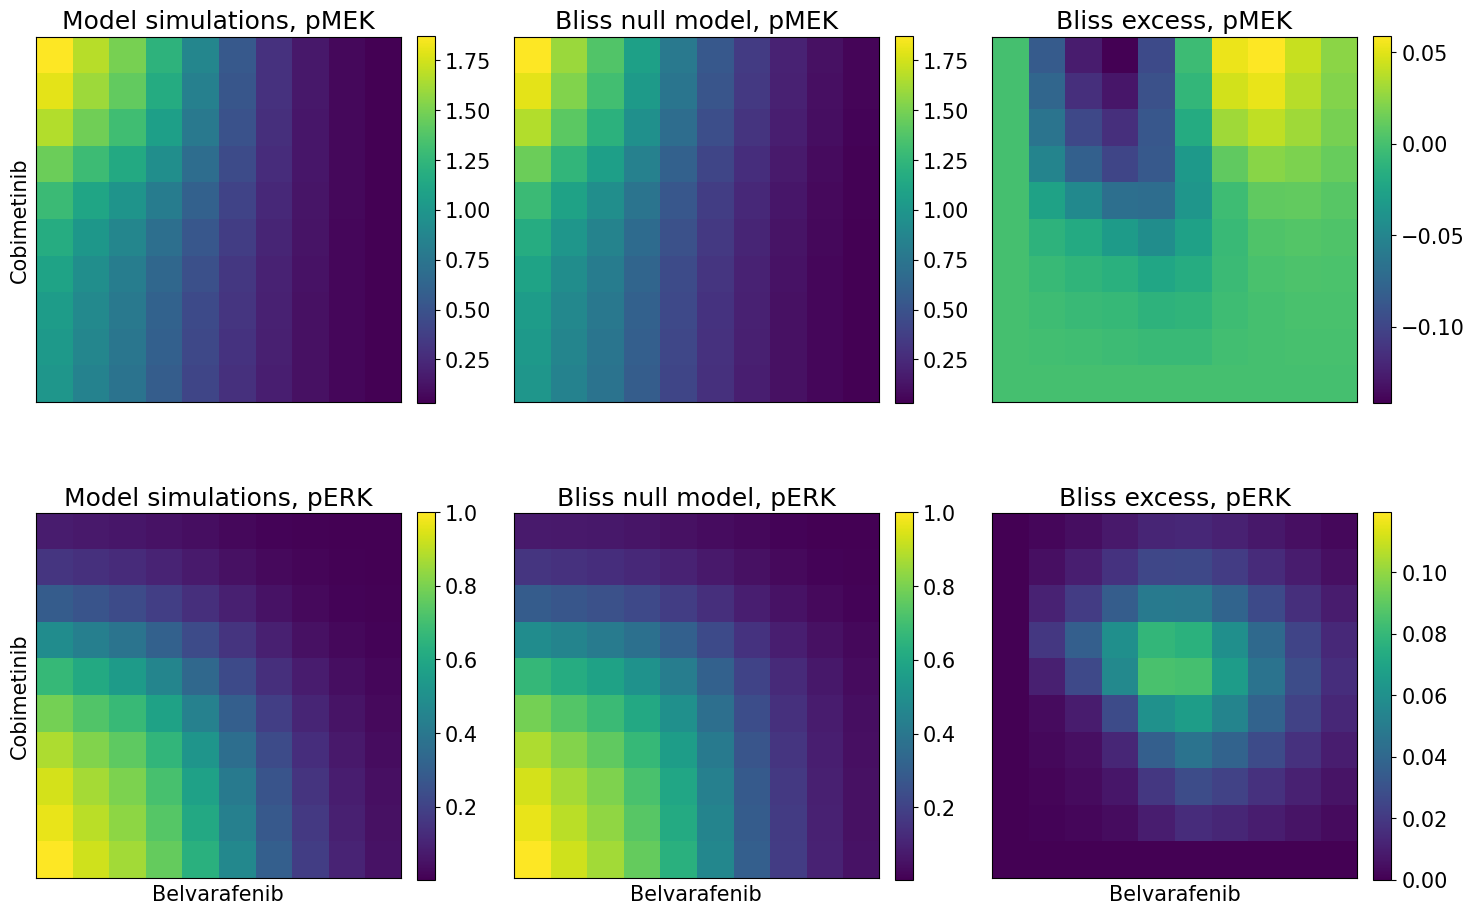

In [16]:
# Loads dataframes
dr_df_w_CRAF = pd.read_csv("data/Steady_state_dose_responses/reclaim_PRAFi_no_CRAF")
dr_df_n_CRAF = pd.read_csv("data/Steady_state_dose_responses/PRAFi_Belva_Cobi_SS_NRAS_Q61_no_CRAF_feedback")
params = list(dr_df_w_CRAF.columns)[2:]
params = ['pMEK', 'pERK']
#params = ['pMEK_obs', 'pERK_obs']

# extract drugless condition
zero_dose_n_CRAF_df = dr_df_n_CRAF.iloc[0]
zero_dose_w_CRAF_df = dr_df_w_CRAF.iloc[0]


#compare synergies among set of cooperative parameters
fig_n_CRAF, ax_n_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
fig_w_CRAF, ax_w_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
plt_titles=['Model simulations', 'Bliss null model',  'Bliss excess'];

for i in range(len(params)):
    #print(params[i])
    #create and fit the Bliss models
    bliss_n_CRAF = Bliss()
    bliss_w_CRAF = Bliss()
    D1_n_CRAF=dr_df_n_CRAF["PRAFi_0_uM"].to_numpy();
    D2_n_CRAF=dr_df_n_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_n_CRAF=dr_df_n_CRAF[params[i]].to_numpy();
    
    D1_w_CRAF=dr_df_w_CRAF["RAFi_0_uM"].to_numpy();
    D2_w_CRAF=dr_df_w_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_w_CRAF=dr_df_w_CRAF[params[i]].to_numpy();
    
    bliss_n_CRAF.fit(D1_n_CRAF,D2_n_CRAF, dr_df_n_CRAF[params[i]]/zero_dose_n_CRAF_df[params[i]]);
    bliss_w_CRAF.fit(D1_w_CRAF,D2_w_CRAF, dr_df_w_CRAF[params[i]]/zero_dose_w_CRAF_df[params[i]]);
    
    #reshape E_sim to matrix
    dr_df_mat_n_CRAF = dr_df_n_CRAF.set_index(["PRAFi_0_uM","MEKi_0_uM"])
    matrix_n_CRAF = dr_df_mat_n_CRAF[[params[i]]].pivot_table(index = "PRAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_n_CRAF = matrix_n_CRAF/zero_dose_n_CRAF_df[params[i]]
    
    dr_df_mat_w_CRAF = dr_df_w_CRAF.set_index(["RAFi_0_uM","MEKi_0_uM"])
    matrix_w_CRAF = dr_df_mat_w_CRAF[[params[i]]].pivot_table(index = "RAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_w_CRAF = matrix_w_CRAF/zero_dose_w_CRAF_df[params[i]]
    
    #extract bliss reference and bliss excess
    E_mat_bliss_ref_n_CRAF=np.rot90(bliss_n_CRAF.reference.reshape(np.shape(matrix_n_CRAF)));
    E_mat_bliss_syn_n_CRAF=np.rot90(bliss_n_CRAF.synergy.reshape(np.shape(matrix_n_CRAF)));
    matrix_n_CRAF = np.rot90(matrix_n_CRAF)
    
    E_mat_bliss_ref_w_CRAF=np.rot90(bliss_w_CRAF.reference.reshape(np.shape(matrix_w_CRAF)));
    E_mat_bliss_syn_w_CRAF=np.rot90(bliss_w_CRAF.synergy.reshape(np.shape(matrix_w_CRAF)));
    matrix_w_CRAF = np.rot90(matrix_w_CRAF)

    
    max_simulation = np.max(np.concatenate((matrix_n_CRAF,matrix_w_CRAF)))
    max_excess = np.max(np.concatenate((E_mat_bliss_ref_n_CRAF,E_mat_bliss_ref_w_CRAF)))
    max_syn = np.max(np.concatenate((E_mat_bliss_syn_n_CRAF,E_mat_bliss_syn_w_CRAF)))
    print(max_syn,max_excess,max_simulation)
    condition_max = [max_simulation,max_excess,max_syn]
    
    Es_n_CRAF=[matrix_n_CRAF, E_mat_bliss_ref_n_CRAF, E_mat_bliss_syn_n_CRAF];
    Es_w_CRAF=[matrix_w_CRAF, E_mat_bliss_ref_w_CRAF, E_mat_bliss_syn_w_CRAF];
    #print(E_mat_bliss_syn_n_CRAF)
    for j in range(len(plt_titles)):
        im=ax_n_CRAF[i,j].imshow(Es_n_CRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_n_CRAF.colorbar(im, ax=ax_n_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_n_CRAF[i,j].set_xticks([])
        ax_n_CRAF[i,j].set_yticks([])
        ax_n_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_n_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_n_CRAF[i,j].set_ylabel('Cobimetinib')
            
        im=ax_w_CRAF[i,j].imshow(Es_w_CRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_w_CRAF.colorbar(im, ax=ax_w_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_w_CRAF[i,j].set_xticks([])
        ax_w_CRAF[i,j].set_yticks([])
        ax_w_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_w_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_w_CRAF[i,j].set_ylabel('Cobimetinib')
fig_n_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_n_CRAF.tight_layout()
fig_n_CRAF.savefig("figures/heatmaps/Scaled_PRAFi_Belva_Cobi_SS_NRAS_Q61_no_CRAF_feedback.svg",format='svg')
fig_w_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_w_CRAF.tight_layout()
fig_w_CRAF.savefig("figures/heatmaps/Scaled_rPRAFi_Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback.svg",format='svg')




## Generate bliss heatmaps (absolute weighting)

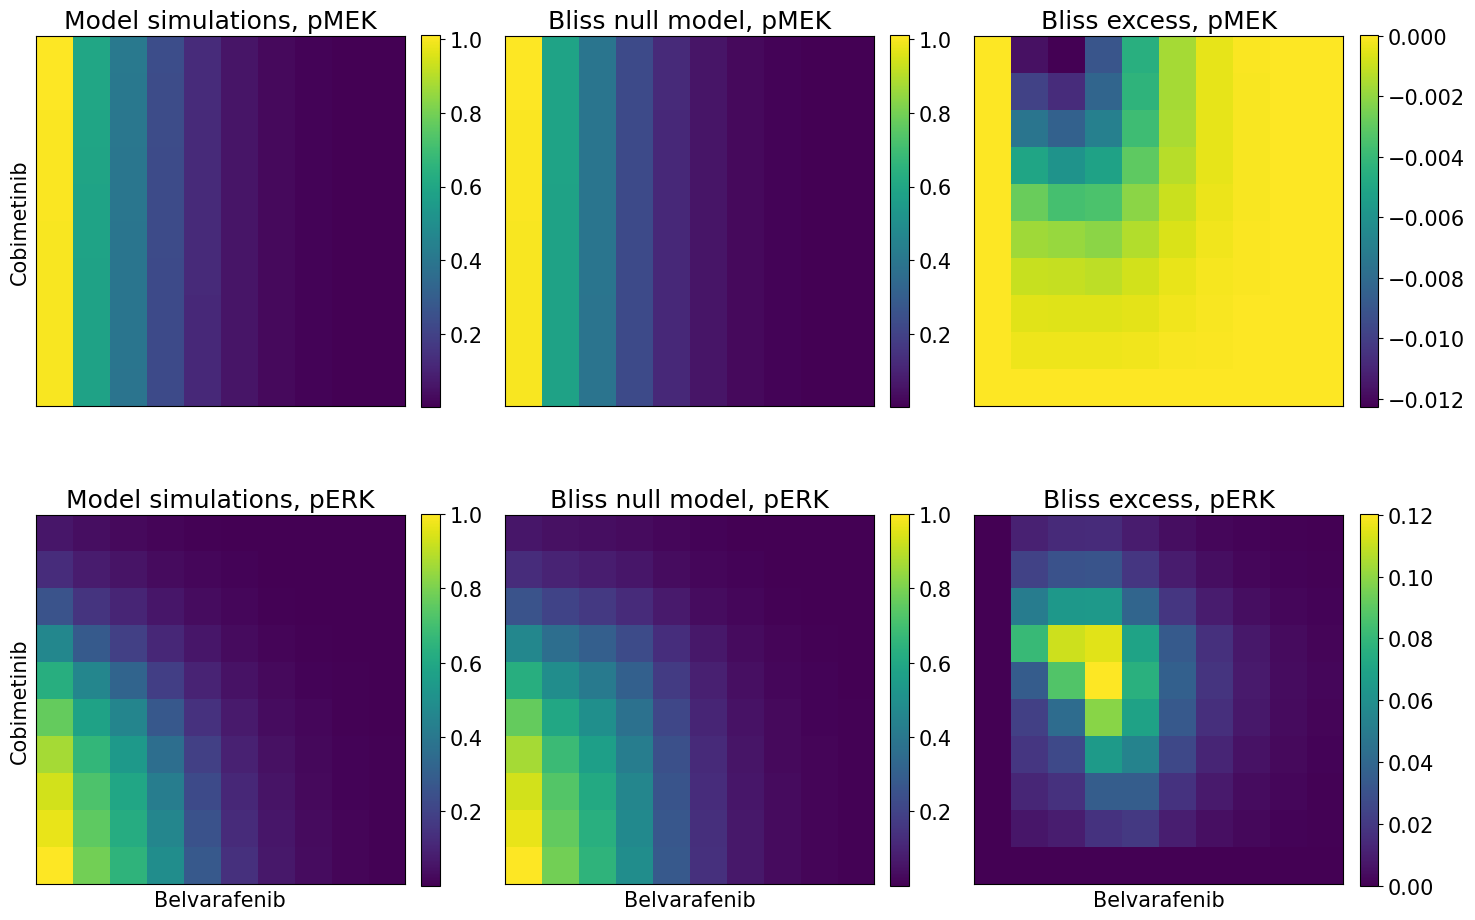

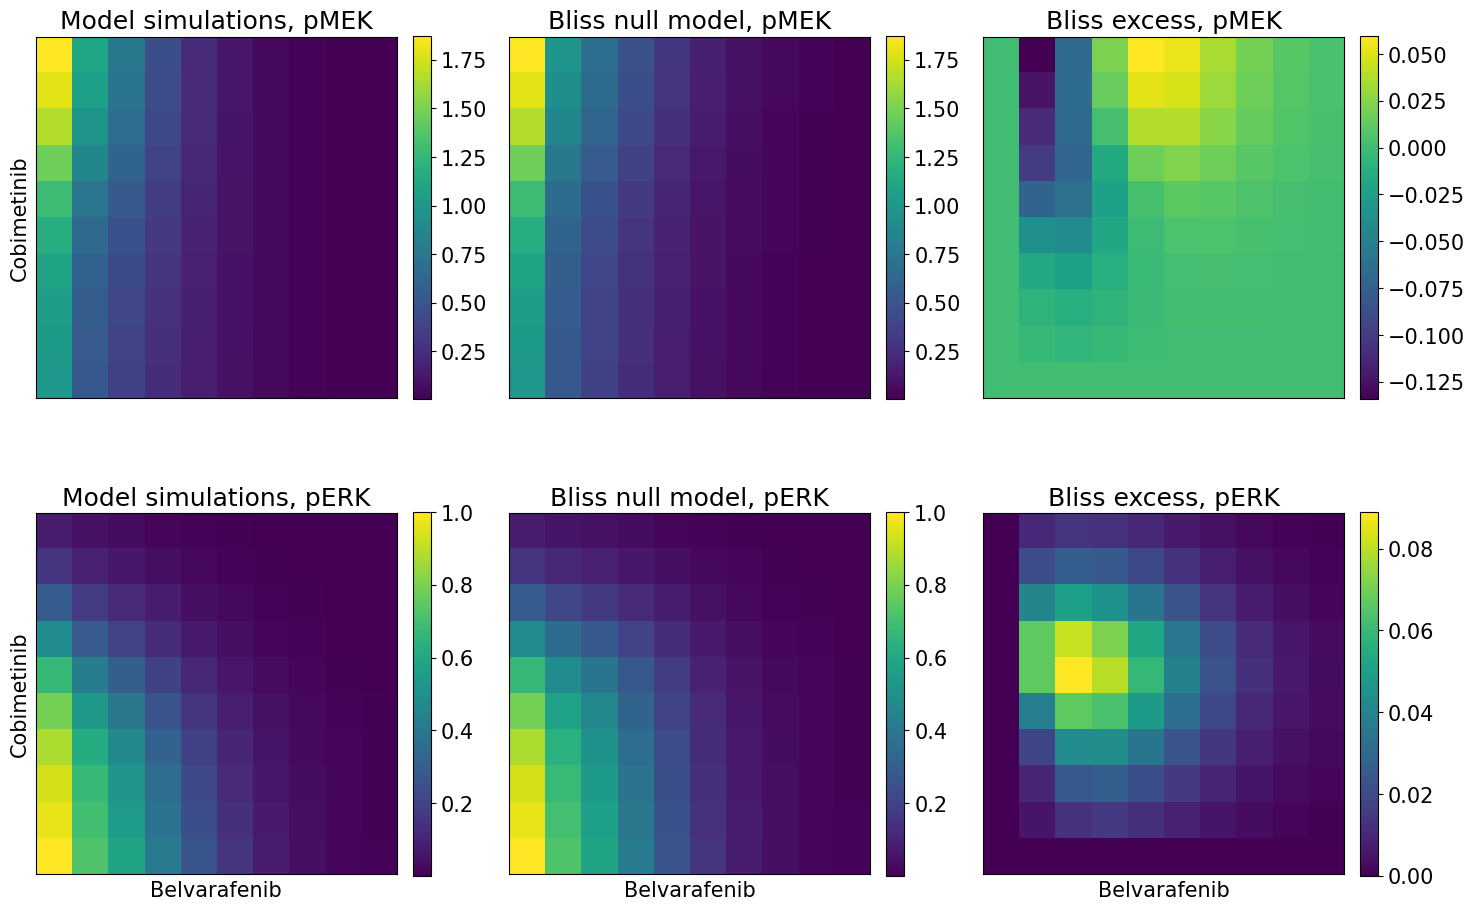

In [4]:
# extract drugless condition
zero_dose_n_CRAF_df = dr_df_n_CRAF.iloc[0]
zero_dose_w_CRAF_df = dr_df_w_CRAF.iloc[0]


#compare synergies among set of cooperative parameters
fig_n_CRAF, ax_n_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
fig_w_CRAF, ax_w_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
plt_titles=['Model simulations', 'Bliss null model',  'Bliss excess'];

for i in range(len(params)):
    #print(params[i])
    #create and fit the Bliss models
    bliss_n_CRAF = Bliss()
    bliss_w_CRAF = Bliss()
    D1_n_CRAF=dr_df_n_CRAF["PRAFi_0_uM"].to_numpy();
    D2_n_CRAF=dr_df_n_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_n_CRAF=dr_df_n_CRAF[params[i]].to_numpy();
    
    D1_w_CRAF=dr_df_w_CRAF["PRAFi_0_uM"].to_numpy();
    D2_w_CRAF=dr_df_w_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_w_CRAF=dr_df_w_CRAF[params[i]].to_numpy();
    
    bliss_n_CRAF.fit(D1_n_CRAF,D2_n_CRAF, dr_df_n_CRAF[params[i]]/zero_dose_n_CRAF_df[params[i]]);
    bliss_w_CRAF.fit(D1_w_CRAF,D2_w_CRAF, dr_df_w_CRAF[params[i]]/zero_dose_w_CRAF_df[params[i]]);
    
    #reshape E_sim to matrix
    dr_df_mat_n_CRAF = dr_df_n_CRAF.set_index(["PRAFi_0_uM","MEKi_0_uM"])
    matrix_n_CRAF = dr_df_mat_n_CRAF[[params[i]]].pivot_table(index = "PRAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_n_CRAF = matrix_n_CRAF/zero_dose_n_CRAF_df[params[i]]
    
    dr_df_mat_w_CRAF = dr_df_w_CRAF.set_index(["PRAFi_0_uM","MEKi_0_uM"])
    matrix_w_CRAF = dr_df_mat_w_CRAF[[params[i]]].pivot_table(index = "PRAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_w_CRAF = matrix_w_CRAF/zero_dose_w_CRAF_df[params[i]]
    
    #extract bliss reference and bliss excess
    E_mat_bliss_ref_n_CRAF=np.rot90(bliss_n_CRAF.reference.reshape(np.shape(matrix_n_CRAF)));
    E_mat_bliss_syn_n_CRAF=np.rot90(bliss_n_CRAF.synergy.reshape(np.shape(matrix_n_CRAF)));
    matrix_n_CRAF = np.rot90(matrix_n_CRAF)
    
    E_mat_bliss_ref_w_CRAF=np.rot90(bliss_w_CRAF.reference.reshape(np.shape(matrix_w_CRAF)));
    E_mat_bliss_syn_w_CRAF=np.rot90(bliss_w_CRAF.synergy.reshape(np.shape(matrix_w_CRAF)));
    matrix_w_CRAF = np.rot90(matrix_w_CRAF)

    
    max_simulation = np.max(np.concatenate((matrix_n_CRAF,matrix_w_CRAF)))
    max_excess = np.max(np.concatenate((E_mat_bliss_ref_n_CRAF,E_mat_bliss_ref_w_CRAF)))
    max_syn = np.max(np.concatenate((E_mat_bliss_syn_w_CRAF,E_mat_bliss_syn_w_CRAF)))
    condition_max = [max_simulation,max_excess,max_syn]
    
    Es_n_CRAF=[matrix_n_CRAF, E_mat_bliss_ref_n_CRAF, E_mat_bliss_syn_n_CRAF];
    Es_w_CRAF=[matrix_w_CRAF, E_mat_bliss_ref_w_CRAF, E_mat_bliss_syn_w_CRAF];
    
    for j in range(len(plt_titles)):
        im=ax_n_CRAF[i,j].imshow(Es_n_CRAF[j], extent=[0, 1, 0, 1])
        fig_n_CRAF.colorbar(im, ax=ax_n_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_n_CRAF[i,j].set_xticks([])
        ax_n_CRAF[i,j].set_yticks([])
        ax_n_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_n_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_n_CRAF[i,j].set_ylabel('Cobimetinib')
            
        im=ax_w_CRAF[i,j].imshow(Es_w_CRAF[j], extent=[0, 1, 0, 1])
        fig_w_CRAF.colorbar(im, ax=ax_w_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_w_CRAF[i,j].set_xticks([])
        ax_w_CRAF[i,j].set_yticks([])
        ax_w_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_w_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_w_CRAF[i,j].set_ylabel('Cobimetinib')
fig_n_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_n_CRAF.tight_layout()
fig_n_CRAF.savefig("figures/heatmaps/PRAFi_Belva_Cobi_SS_NRAS_Q61_n_CRAF_feedback.svg",format='svg')
fig_w_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_w_CRAF.tight_layout()
fig_w_CRAF.savefig("figures/heatmaps/PRAFi_Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback.svg",format='svg')


0.060669936913206046 1.8740807162124826 1.8740807162124826
[[0.99999984 1.03951453 1.07742006 1.14202826 1.2347659  1.34186868
  1.43613046 1.49773104 1.52324237 1.51403729]
 [0.99999997 1.04048637 1.07859082 1.14202484 1.23088906 1.33340013
  1.42632898 1.49021989 1.51883114 1.51185903]
 [0.99999985 1.04163127 1.07962939 1.14062974 1.22345231 1.31903701
  1.40976738 1.47700802 1.51073415 1.5077374 ]
 [0.9999999  1.042746   1.07989619 1.13698753 1.21183413 1.29890784
  1.38629323 1.4572735  1.49795542 1.50094779]
 [0.99999972 1.04772712 1.08430538 1.13464494 1.19950196 1.27703573
  1.35985841 1.4336306  1.48160986 1.49180116]
 [0.99999985 1.0524384  1.09445357 1.14481104 1.1932244  1.25911681
  1.33637147 1.4110573  1.46494344 1.4819592 ]
 [1.00000001 1.05411271 1.09817816 1.15559729 1.19813301 1.24791818
  1.31904249 1.39310406 1.45081257 1.47319686]
 [0.99999984 1.05511862 1.0999151  1.15983985 1.20766212 1.24264845
  1.30786377 1.38064727 1.44038076 1.46645427]
 [0.99999985 1.055679

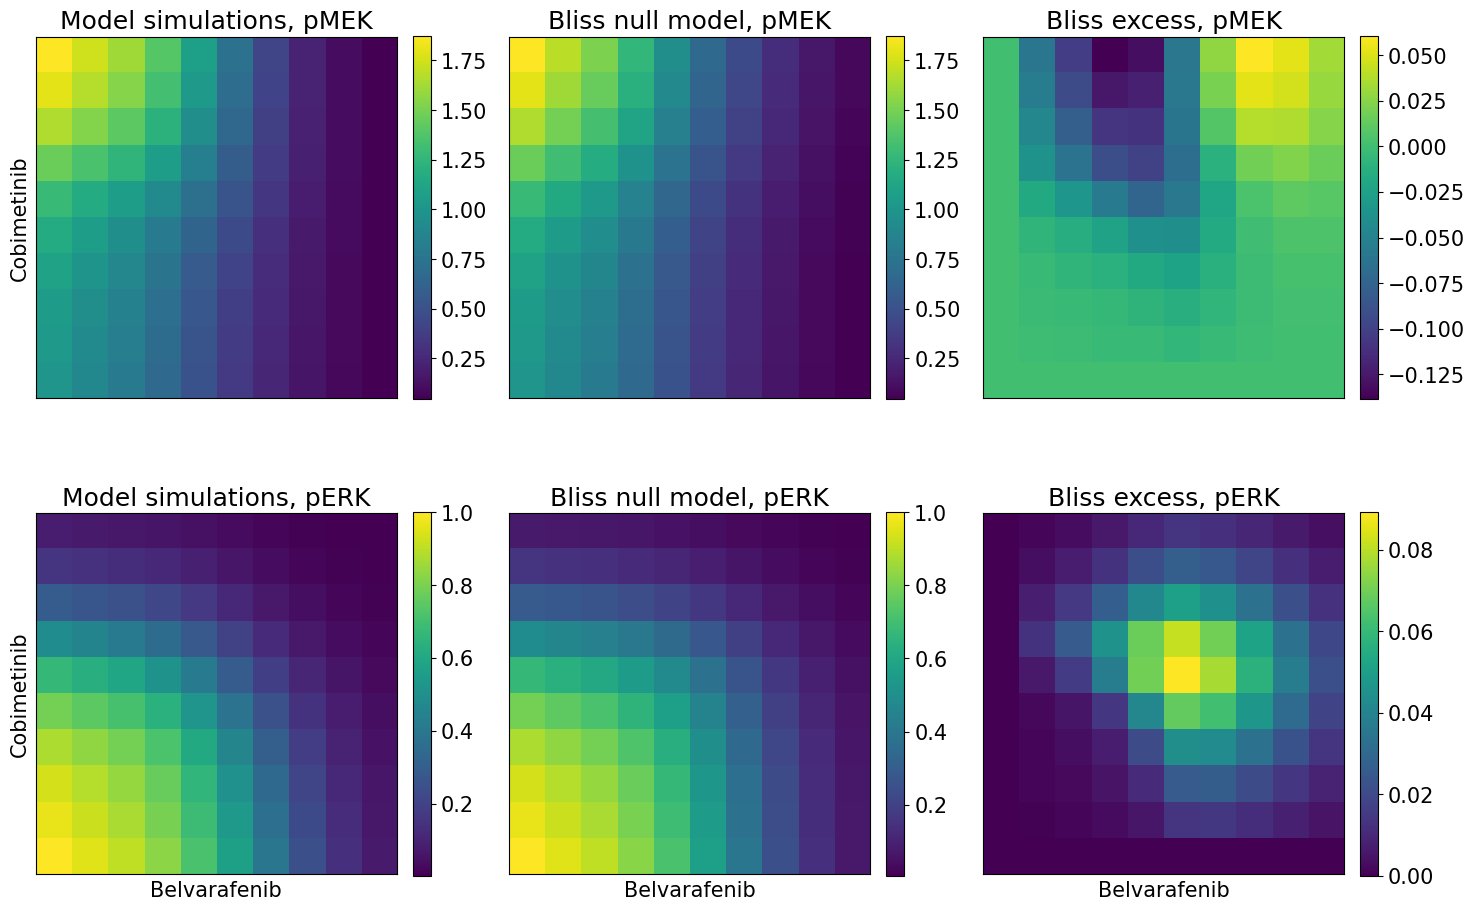

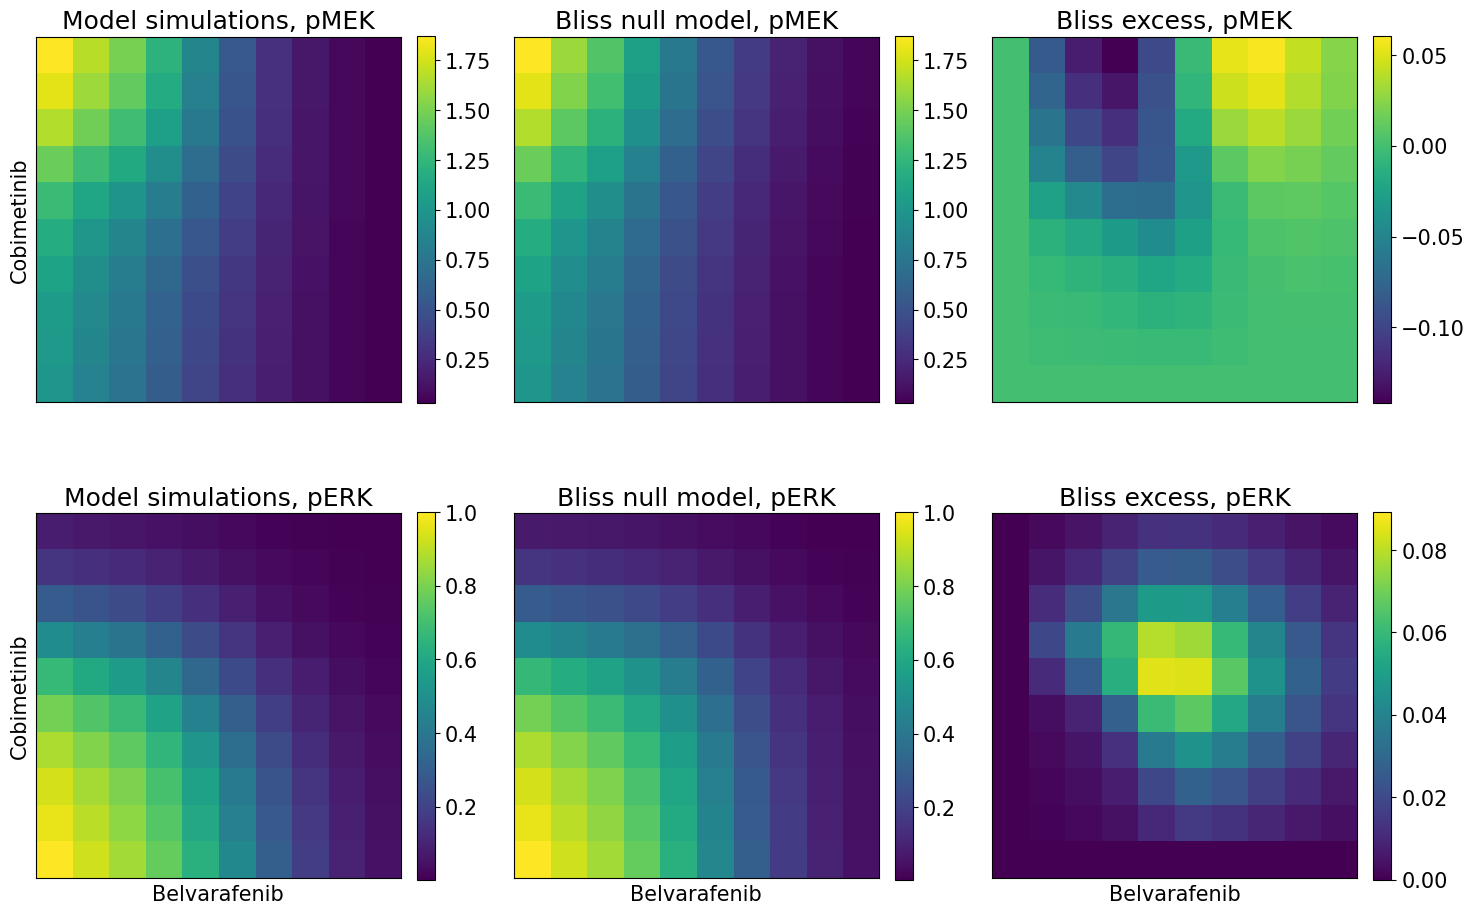

In [18]:
# Loads dataframes
dr_df_w_CRAF = pd.read_csv("data/Steady_state_dose_responses/reclaim_PRAFi_no_CRAF")
dr_df_n_CRAF = pd.read_csv("data/Steady_state_dose_responses/PRAFi_Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback")
params = list(dr_df_w_CRAF.columns)[2:]
params = ['pMEK', 'pERK']
#params = ['pMEK_obs', 'pERK_obs']

# extract drugless condition
zero_dose_n_CRAF_df = dr_df_n_CRAF.iloc[0]
zero_dose_w_CRAF_df = dr_df_w_CRAF.iloc[0]


#compare synergies among set of cooperative parameters
fig_n_CRAF, ax_n_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
fig_w_CRAF, ax_w_CRAF = plt.subplots(len(params), 3,figsize=(15,10))
plt_titles=['Model simulations', 'Bliss null model',  'Bliss excess'];

for i in range(len(params)):
    #print(params[i])
    #create and fit the Bliss models
    bliss_n_CRAF = Bliss()
    bliss_w_CRAF = Bliss()
    D1_n_CRAF=dr_df_n_CRAF["PRAFi_0_uM"].to_numpy();
    D2_n_CRAF=dr_df_n_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_n_CRAF=dr_df_n_CRAF[params[i]].to_numpy();
    
    D1_w_CRAF=dr_df_w_CRAF["RAFi_0_uM"].to_numpy();
    D2_w_CRAF=dr_df_w_CRAF["MEKi_0_uM"].to_numpy(); 
    E_sim_w_CRAF=dr_df_w_CRAF[params[i]].to_numpy();
    
    bliss_n_CRAF.fit(D1_n_CRAF,D2_n_CRAF, dr_df_n_CRAF[params[i]]/zero_dose_n_CRAF_df[params[i]]);
    bliss_w_CRAF.fit(D1_w_CRAF,D2_w_CRAF, dr_df_w_CRAF[params[i]]/zero_dose_w_CRAF_df[params[i]]);
    
    #reshape E_sim to matrix
    dr_df_mat_n_CRAF = dr_df_n_CRAF.set_index(["PRAFi_0_uM","MEKi_0_uM"])
    matrix_n_CRAF = dr_df_mat_n_CRAF[[params[i]]].pivot_table(index = "PRAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_n_CRAF = matrix_n_CRAF/zero_dose_n_CRAF_df[params[i]]
    
    dr_df_mat_w_CRAF = dr_df_w_CRAF.set_index(["RAFi_0_uM","MEKi_0_uM"])
    matrix_w_CRAF = dr_df_mat_w_CRAF[[params[i]]].pivot_table(index = "RAFi_0_uM",columns = "MEKi_0_uM",values = params[i]).to_numpy()
    matrix_w_CRAF = matrix_w_CRAF/zero_dose_w_CRAF_df[params[i]]
    
    #extract bliss reference and bliss excess
    E_mat_bliss_ref_n_CRAF=np.rot90(bliss_n_CRAF.reference.reshape(np.shape(matrix_n_CRAF)));
    E_mat_bliss_syn_n_CRAF=np.rot90(bliss_n_CRAF.synergy.reshape(np.shape(matrix_n_CRAF)));
    matrix_n_CRAF = np.rot90(matrix_n_CRAF)
    
    E_mat_bliss_ref_w_CRAF=np.rot90(bliss_w_CRAF.reference.reshape(np.shape(matrix_w_CRAF)));
    E_mat_bliss_syn_w_CRAF=np.rot90(bliss_w_CRAF.synergy.reshape(np.shape(matrix_w_CRAF)));
    matrix_w_CRAF = np.rot90(matrix_w_CRAF)

    
    max_simulation = np.max(np.concatenate((matrix_n_CRAF,matrix_w_CRAF)))
    max_excess = np.max(np.concatenate((E_mat_bliss_ref_n_CRAF,E_mat_bliss_ref_w_CRAF)))
    max_syn = np.max(np.concatenate((E_mat_bliss_syn_n_CRAF,E_mat_bliss_syn_w_CRAF)))
    print(max_syn,max_excess,max_simulation)
    condition_max = [max_simulation,max_excess,max_syn]
    print(matrix_n_CRAF/matrix_w_CRAF)
    Es_n_CRAF=[matrix_n_CRAF, E_mat_bliss_ref_n_CRAF, E_mat_bliss_syn_n_CRAF];
    Es_w_CRAF=[matrix_w_CRAF, E_mat_bliss_ref_w_CRAF, E_mat_bliss_syn_w_CRAF];
    #print(E_mat_bliss_syn_n_CRAF)
    for j in range(len(plt_titles)):
        im=ax_n_CRAF[i,j].imshow(Es_n_CRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_n_CRAF.colorbar(im, ax=ax_n_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_n_CRAF[i,j].set_xticks([])
        ax_n_CRAF[i,j].set_yticks([])
        ax_n_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_n_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_n_CRAF[i,j].set_ylabel('Cobimetinib')
            
        im=ax_w_CRAF[i,j].imshow(Es_w_CRAF[j], extent=[0, 1, 0, 1],vmax = condition_max[j])
        fig_w_CRAF.colorbar(im, ax=ax_w_CRAF[i,j], fraction=0.046, pad=0.04)
        ax_w_CRAF[i,j].set_xticks([])
        ax_w_CRAF[i,j].set_yticks([])
        ax_w_CRAF[i,j].title.set_text(plt_titles[j]+ f", {params[i]}")
        if (i==len(params)-1):    
            ax_w_CRAF[i,j].set_xlabel('Belvarafenib')
        if (j==0):    
            ax_w_CRAF[i,j].set_ylabel('Cobimetinib')
fig_n_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_n_CRAF.tight_layout()
fig_n_CRAF.savefig("figures/heatmaps/Scaled_PRAFi_Belva_Cobi_SS_NRAS_Q61_no_CRAF_feedback.svg",format='svg')
fig_w_CRAF.subplots_adjust(wspace=0, hspace=0)
fig_w_CRAF.tight_layout()
fig_w_CRAF.savefig("figures/heatmaps/Scaled_rPRAFi_Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback.svg",format='svg')
